# **Quelques techniques de réduction de la dimensionalité**

Chaque image est une observation, chaque pixel est une variable. Par conséquent ça fait vite des problème de grande dimension. Et bien sûr, plus c'est gros, plus c'est long donc on a souvent intérêt à réduire la dimensionalité du problème. Sans compter que dans le cas précis d'une image, de nombreux pixel peuvent s'avérer peu informatif donc c'est d'autant plus intéressant de s'en passer.

On va bosser sur MNIST parce que ce dataset est facilement accessible.

In [1]:
# import des librairies
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cv2

In [25]:
# import du dataset
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape

(60000, 28, 28)

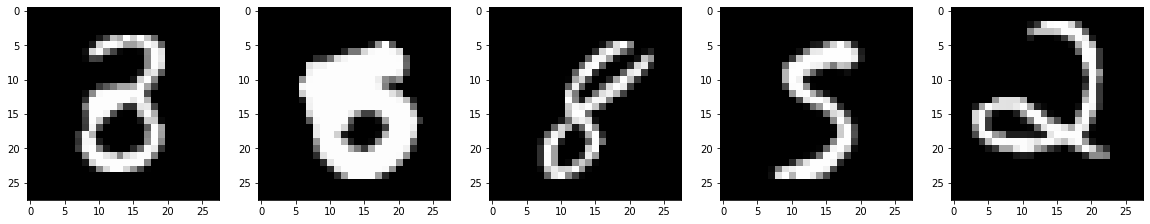

In [26]:
plt.figure(figsize=(20,5))
for k in range(5):
    plt.subplot(1,5,k+1)
    plt.imshow(X_train[np.random.randint(60000)], cmap=plt.cm.gray)

In [27]:
X_train = X_train.reshape(60000,-1)
X_train.shape

(60000, 784)

### **1. PCA**

PCA pour *Principal Components Analysis*.

Déjà vu, n'est-ce pas ? Ça n'a donc pas de secret pour vous. Petit rappel au cas où, l'idée de l'ACP (PCA pour les english) est de réduire la dimension en construisant un jeu de variables à partir de combinaisons linéaires des variables initiales tout en conservant le maximum de la variance.

Bon ben y a plus qu'à appliquer ça à votre image maintenant.

Évidemment, on oublie pas la nécessité de normaliser...

In [28]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_train.shape

(60000, 784)

In [29]:
# On peut faire une ACP la question c'est comment on choisit le nombre de composantes
# Une manière simple et empirique est de tester sur une partie du dataset puis généraliser
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train[:5000])

cumsum = np.cumsum(pca.explained_variance_ratio_)
nb_dim = np.argmax(cumsum >= 0.95) + 1

print("Nombre de composants expliquant 95% de la variance :", nb_dim)

Nombre de composants expliquant 95% de la variance : 249


In [30]:
pca = PCA(n_components=nb_dim)
X_train_pca = pca.fit_transform(X_train)
X_train_pca.shape

(60000, 249)

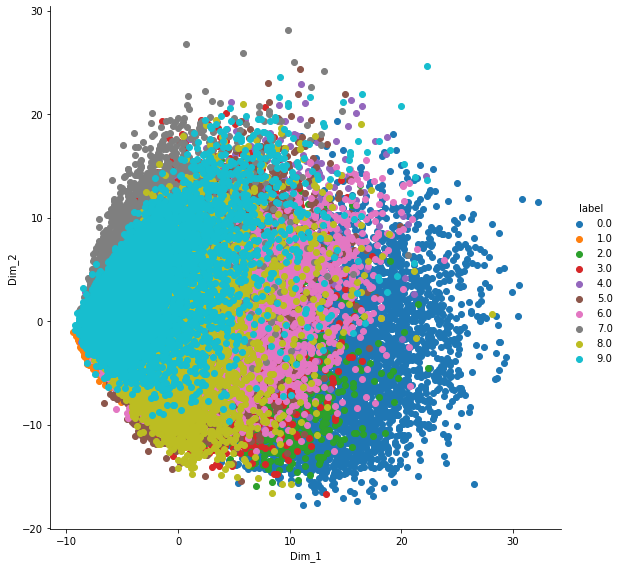

In [31]:
# en dimension 2 pour visualiser
pca = PCA(n_components=2)
X_train_pca2 = pca.fit_transform(X_train)
X_train_pca2.shape

pca2_data = np.vstack((X_train_pca2.T, y_train)).T
pca2_df = pd.DataFrame(data=pca2_data, columns=("Dim_1", "Dim_2", "label"))

sns.FacetGrid(pca2_df, hue="label", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend();

### **2. ICA**

ICA pour *Independant Components Analysis*.

Ça on l'a pas vu mais j'invite ceux que ça intéresse à aller voir plus loin, par [là](https://fr.wikipedia.org/wiki/Analyse_en_composantes_ind%C3%A9pendantes). C'est le même principe que la PCA mais cela fait appel à la notion de [moment statistique](https://fr.wikipedia.org/wiki/Moment_(probabilit%C3%A9s)).

Pour faire "simple", la variance est le moment d'ordre 2 et il y a des moments d'ordre supérieur. Tous sont une mesure de la dispersion d'une variable.
Dans l'ICA, au lieu d'essayer d'avoir la plus grande variance avec le moins de composants, on va maximiser des moments d'ordre supérieur à 2.

L'iCA peut s'appliquer dans un cadre théorique plus général par contre, on perd avec l'ICA un des avantages de la PCA, à savoir on ne pas ordonner les composants c'est-à-dire qu'on ne peut pas associer à tel composant, tel pourcentage de la dispersion expliquée...

In [32]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=nb_dim)
X_train_ica = ica.fit_transform(X_train)
X_train_ica.shape

/home/elka/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


(60000, 249)

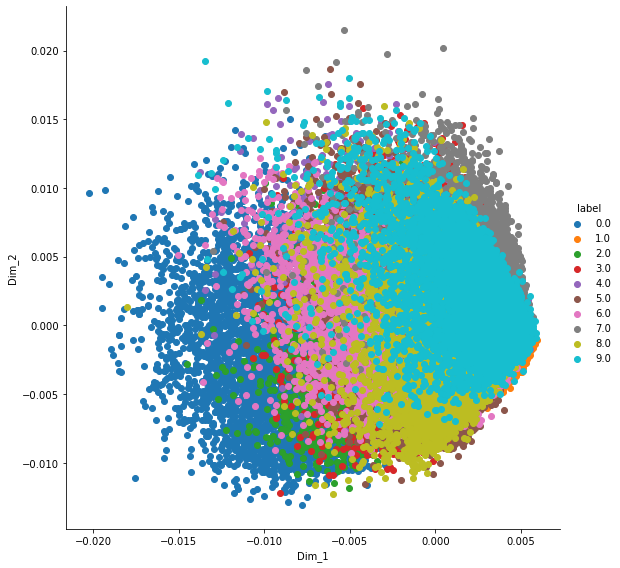

In [33]:
# en dimension 2 pour visualiser
ica = FastICA(n_components=2)
X_train_ica2 = ica.fit_transform(X_train)
X_train_ica2.shape

ica2_data = np.vstack((X_train_ica2.T, y_train)).T
ica2_df = pd.DataFrame(data=ica2_data, columns=("Dim_1", "Dim_2", "label"))

sns.FacetGrid(ica2_df, hue="label", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend();

### **3. t-SNE**

t-SNE pour *t-Distributed stochastic neighbor embedding* t faisant référence à la loi de Student.

On va faire rapide : ce qu'il faut retenir de cette méthode c'est qu'elle est plus récente et non linéaire (oui oui les petits malins, il y a aussi la Kernel PCA pour les problèmes non linéaires, c'est vrai, mais ça date des années 30) par contre elle est longue à entraîner si on veut conserver de nombreux composants sinon il faut n'en garder que très peu. On s'en sert généralement plus pour la visualisation que pour la réduction de la dimension dans un but d'entraînement de modèles de deep learning. Par ailleurs, ce n'est pas un algorithme qui permet de mettre en place un modèle réutilisable (c'est-à-dire qu'il n'y a pas de méthode transform possible à appliquer sur de nouvelles observations).

In [34]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, random_state=0)
X_train_tsne = tsne_model.fit_transform(X_train[:2000])

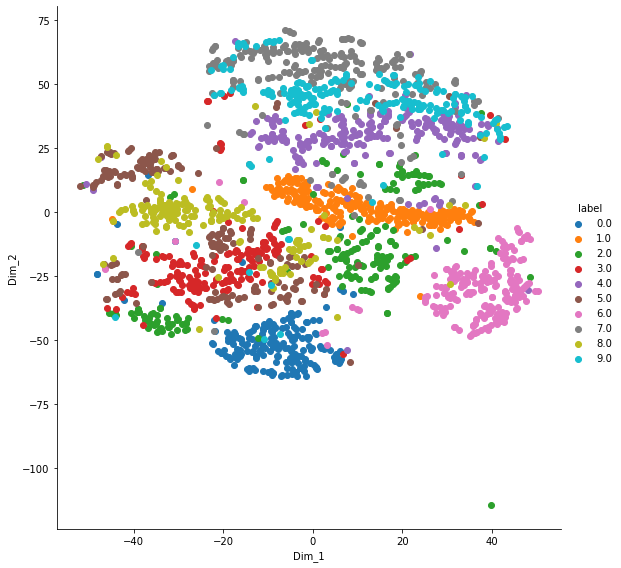

In [35]:
tsne_data = np.vstack((X_train_tsne.T, y_train[:2000])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

sns.FacetGrid(tsne_df, hue="label", height=8).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend();

### **4. UMAP**

UMAP pour *Uniform Manifold Approximation and Projection*.

Une autre technique de réduction de la dimension qui est plus performante pour préserver la structure des données à l'échelle globale: les points proches dans l'espace de grande dimension le sont toujours dans l'espace de plus petite dimenseion mais c'est aussi le cas pour les points éloignés. C'est relativement rapide et donc plus adapté à de large dataset.

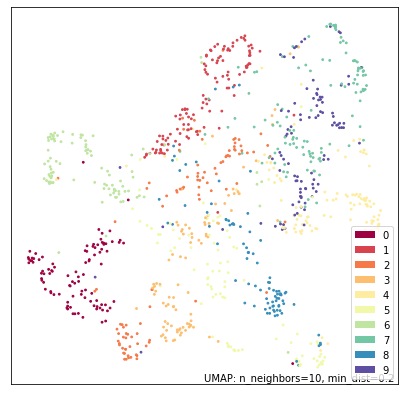

In [36]:
import umap
import umap.plot

mapper = umap.UMAP(n_neighbors=10, min_dist=0.2, n_components=2).fit(X_train[:1000])
umap.plot.points(mapper, labels=y_train[:1000], width=500, height=500);